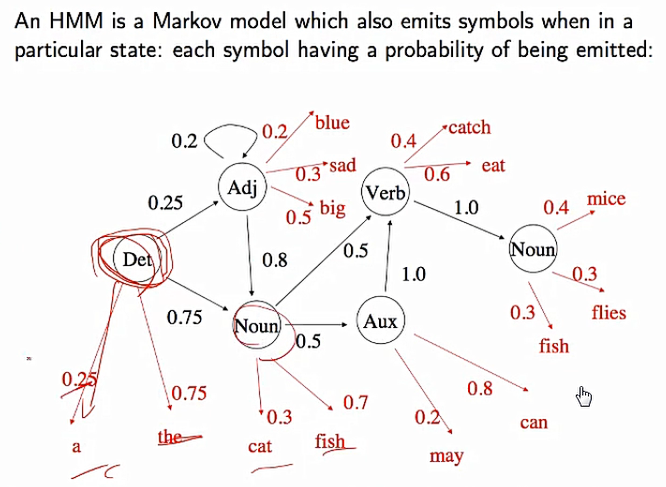

假设我们的单词集： words = w1 ... wN

Tag集： tags = t1 ... tN

并且上课我们讲了，

P(tags | words) 正比于 P(ti | t{i-1}) * P(wi | ti)

为了找一个句子的tag，

我们其实就是找的最好的一套tags，让他最能够符合给定的单词(words)。

In [1]:
import nltk
import sys
from nltk.corpus import brown

## 预处理词库

这里需要做的预处理是：给词们加上开始和结束符号。

Brown里面的句子都是自己标注好了的，长这个样子：(I , NOUN), (LOVE, VERB), (YOU, NOUN)

那么，我们的开始符号也得跟他的格式符合，

In [3]:


brown_tags_words = [ ]
for sent in brown.tagged_sents():
    # 先加开头
    brown_tags_words.append( ("START", "START") )
    # 为了省事儿，我们把tag都省略成前两个字母
    brown_tags_words.extend([ (tag[:2], word) for (word, tag) in sent ])#tag自取前两个 如VBD->VB
    # 加个结尾
    brown_tags_words.append( ("END", "END") )



In [2]:
brown.tagged_sents()

[[('The', 'AT'), ('Fulton', 'NP-TL'), ('County', 'NN-TL'), ('Grand', 'JJ-TL'), ('Jury', 'NN-TL'), ('said', 'VBD'), ('Friday', 'NR'), ('an', 'AT'), ('investigation', 'NN'), ('of', 'IN'), ("Atlanta's", 'NP$'), ('recent', 'JJ'), ('primary', 'NN'), ('election', 'NN'), ('produced', 'VBD'), ('``', '``'), ('no', 'AT'), ('evidence', 'NN'), ("''", "''"), ('that', 'CS'), ('any', 'DTI'), ('irregularities', 'NNS'), ('took', 'VBD'), ('place', 'NN'), ('.', '.')], [('The', 'AT'), ('jury', 'NN'), ('further', 'RBR'), ('said', 'VBD'), ('in', 'IN'), ('term-end', 'NN'), ('presentments', 'NNS'), ('that', 'CS'), ('the', 'AT'), ('City', 'NN-TL'), ('Executive', 'JJ-TL'), ('Committee', 'NN-TL'), (',', ','), ('which', 'WDT'), ('had', 'HVD'), ('over-all', 'JJ'), ('charge', 'NN'), ('of', 'IN'), ('the', 'AT'), ('election', 'NN'), (',', ','), ('``', '``'), ('deserves', 'VBZ'), ('the', 'AT'), ('praise', 'NN'), ('and', 'CC'), ('thanks', 'NNS'), ('of', 'IN'), ('the', 'AT'), ('City', 'NN-TL'), ('of', 'IN-TL'), ('Atlant


## 词统计

这个时候，我们要把我们所有的词库中拥有的单词与tag之间的关系，做个简单粗暴的统计。

也就是我们之前说过的B：

P(wi | ti) = count(wi, ti) / count(ti)

你可以自己一个个的loop全部的corpus，

当然，这里NLTK给了我们做统计的工具，（这属于没有什么必要的hack，装起逼来也不X，所以，大家想自己实现，可以去实现，不想的话，就用这里提供的方法）


In [4]:
# 喷射概率
# MLE最大似然估计


# conditional frequency distribution
cfd_tagwords = nltk.ConditionalFreqDist(brown_tags_words)
# conditional probability distribution
cpd_tagwords = nltk.ConditionalProbDist(cfd_tagwords, nltk.MLEProbDist)



In [5]:
cfd_tagwords

ConditionalFreqDist(nltk.probability.FreqDist,
                    {"'": FreqDist({"'": 317}),
                     "''": FreqDist({"''": 8789}),
                     '(': FreqDist({'(': 2263, '[': 1}),
                     '(-': FreqDist({'(': 162}),
                     ')': FreqDist({')': 2272, ']': 1}),
                     ')-': FreqDist({')': 184}),
                     '*': FreqDist({'Not': 185,
                               'nawt': 1,
                               'not': 4415,
                               'nott': 2}),
                     '*-': FreqDist({'Not': 2, 'not': 8}),
                     ',': FreqDist({',': 58153, ':': 1, '[': 1, ']': 1}),
                     ',-': FreqDist({',': 180}),
                     '--': FreqDist({'--': 3431}),
                     '.': FreqDist({'!': 1590,
                               '.': 48812,
                               ':': 46,
                               ';': 5562,
                               '?': 4628}),
               

In [6]:
print("The probability of an adjective (JJ) being 'new' is", cpd_tagwords["JJ"].prob("new"))
print("The probability of a verb (VB) being 'duck' is", cpd_tagwords["VB"].prob("duck"))

The probability of an adjective (JJ) being 'new' is 0.01472344917632025
The probability of a verb (VB) being 'duck' is 6.042713350943527e-05


A的计算

好，接下来，按照课上讲的，还有第二个公式需要计算：

P(ti | t{i-1}) = count(t{i-1}, ti) / count(t{i-1})

这个公式跟words没有什么卵关系。它是属于$/隐层的马科夫链/$。

所以 我们先取出所有的tag来。


In [7]:
brown_tags = [tag for (tag, word) in brown_tags_words ]

In [8]:


# count(t{i-1} ti)
# bigram的意思是 前后两个一组，联在一起
cfd_tags= nltk.ConditionalFreqDist(nltk.bigrams(brown_tags))
# P(ti | t{i-1})
cpd_tags = nltk.ConditionalProbDist(cfd_tags, nltk.MLEProbDist)



In [9]:
print("If we have just seen 'DT', the probability of 'NN' is", cpd_tags["DT"].prob("NN"))
print( "If we have just seen 'VB', the probability of 'JJ' is", cpd_tags["VB"].prob("DT"))
print( "If we have just seen 'VB', the probability of 'NN' is", cpd_tags["VB"].prob("NN"))

If we have just seen 'DT', the probability of 'NN' is 0.5057722522030194
If we have just seen 'VB', the probability of 'JJ' is 0.016885067592065053
If we have just seen 'VB', the probability of 'NN' is 0.10970977711020183


## Evaluation问题 反欺诈
一些有趣的结果：

那么，比如， 一句话，"I want to race"， 一套tag，"PP VB TO VB"

他们之间的匹配度有多高呢？

其实就是：

       P(START) * P(PP|START) * P(I | PP) *
   
                P(VB | PP) * P(want | VB) *
            
                P(TO | VB) * P(to | TO) *
            
                P(VB | TO) * P(race | VB) *
            
                P(END | VB)



In [10]:


prob_tagsequence = cpd_tags["START"].prob("PP") * cpd_tagwords["PP"].prob("I") * \
    cpd_tags["PP"].prob("VB") * cpd_tagwords["VB"].prob("want") * \
    cpd_tags["VB"].prob("TO") * cpd_tagwords["TO"].prob("to") * \
    cpd_tags["TO"].prob("VB") * cpd_tagwords["VB"].prob("race") * \
    cpd_tags["VB"].prob("END")

print( "The probability of the tag sequence 'START PP VB TO VB END' for 'I want to race' is:", prob_tagsequence)



The probability of the tag sequence 'START PP VB TO VB END' for 'I want to race' is: 1.0817766461150474e-14



## Viterbi 的实现 Recognition问题

如果我们手上有一句话，怎么知道最符合的tag是哪组呢？

首先，我们拿出所有独特的tags（也就是tags的全集）


In [11]:
brown_tags

['START',
 'AT',
 'NP',
 'NN',
 'JJ',
 'NN',
 'VB',
 'NR',
 'AT',
 'NN',
 'IN',
 'NP',
 'JJ',
 'NN',
 'NN',
 'VB',
 '``',
 'AT',
 'NN',
 "''",
 'CS',
 'DT',
 'NN',
 'VB',
 'NN',
 '.',
 'END',
 'START',
 'AT',
 'NN',
 'RB',
 'VB',
 'IN',
 'NN',
 'NN',
 'CS',
 'AT',
 'NN',
 'JJ',
 'NN',
 ',',
 'WD',
 'HV',
 'JJ',
 'NN',
 'IN',
 'AT',
 'NN',
 ',',
 '``',
 'VB',
 'AT',
 'NN',
 'CC',
 'NN',
 'IN',
 'AT',
 'NN',
 'IN',
 'NP',
 "''",
 'IN',
 'AT',
 'NN',
 'IN',
 'WD',
 'AT',
 'NN',
 'BE',
 'VB',
 '.',
 'END',
 'START',
 'AT',
 'NP',
 'NN',
 'NN',
 'HV',
 'BE',
 'VB',
 'IN',
 'NP',
 'JJ',
 'NN',
 'NN',
 'NP',
 'NP',
 'TO',
 'VB',
 'NN',
 'IN',
 'JJ',
 '``',
 'NN',
 "''",
 'IN',
 'AT',
 'JJ',
 'NN',
 'WD',
 'BE',
 'VB',
 'IN',
 'NN',
 'NP',
 'NP',
 'NP',
 '.',
 'END',
 'START',
 '``',
 'RB',
 'AT',
 'JJ',
 'NN',
 'IN',
 'JJ',
 'NN',
 'BE',
 'VB',
 "''",
 ',',
 'AT',
 'NN',
 'VB',
 ',',
 '``',
 'IN',
 'AT',
 'JJ',
 'NN',
 'IN',
 'AT',
 'NN',
 ',',
 'AT',
 'NN',
 'IN',
 'NN',
 'CC',
 'AT',
 'NN',

In [12]:


distinct_tags = set(brown_tags)



In [14]:


sentence = ["I", "want", "to", "race" ]
sentlen = len(sentence)



In [15]:
sentlen

4

找到一条最佳路径

接下来，开始维特比：

从1循环到句子的总长N，记为i

每次都找出以tag X为最终节点，长度为i的tag链


In [16]:
viterbi = [ ]



同时，还需要一个回溯器：

从1循环到句子的总长N，记为i

把所有tag X 前一个Tag记下来。


In [17]:
backpointer = [ ]

In [18]:
first_viterbi = { }
first_backpointer = { }
for tag in distinct_tags:
    # don't record anything for the START tag
    if tag == "START": continue
    first_viterbi[ tag ] = cpd_tags["START"].prob(tag) * cpd_tagwords[tag].prob( sentence[0] )
    first_backpointer[ tag ] = "START"

print(first_viterbi)
print(first_backpointer)

{'NR': 0.0, '*-': 0.0, 'RB': 0.0, 'AB': 0.0, '(': 0.0, 'MD': 0.0, 'WR': 0.0, 'UH': 0.0, 'HV': 0.0, "''": 0.0, 'NP': 1.7319067623793952e-06, 'QL': 0.0, ':-': 0.0, '--': 0.0, ':': 0.0, 'IN': 0.0, 'PP': 0.014930900689060006, 'WP': 0.0, 'CC': 0.0, 'PN': 0.0, ',-': 0.0, 'END': 0.0, 'BE': 0.0, '``': 0.0, 'AP': 0.0, '*': 0.0, 'CD': 0.0, "'": 0.0, 'FW': 0.0, 'DO': 0.0, 'RP': 0.0, 'WQ': 0.0, 'EX': 0.0, ',': 0.0, 'DT': 0.0, 'WD': 0.0, ')': 0.0, 'TO': 0.0, 'RN': 0.0, 'NI': 3.3324520848931064e-07, '.-': 0.0, '(-': 0.0, 'OD': 0.0, 'JJ': 0.0, ')-': 0.0, 'CS': 0.0, '.': 0.0, 'NN': 1.0580313619573935e-06, 'AT': 0.0, 'VB': 0.0}
{'NR': 'START', '*-': 'START', 'RB': 'START', 'AB': 'START', '(': 'START', 'MD': 'START', 'WR': 'START', 'UH': 'START', 'HV': 'START', "''": 'START', 'NP': 'START', 'QL': 'START', ':-': 'START', '--': 'START', ':': 'START', 'IN': 'START', 'PP': 'START', 'WP': 'START', 'CC': 'START', 'PN': 'START', ',-': 'START', 'END': 'START', 'BE': 'START', '``': 'START', 'AP': 'START', '*': '



以上，是所有的第一个viterbi 和第一个回溯点。

接下来，把楼上这些，存到Vitterbi和Backpointer两个变量里去


In [19]:
viterbi.append(first_viterbi)
backpointer.append(first_backpointer)

In [20]:
# 我们可以先看一眼，目前最好的tag是啥：
currbest = max(first_viterbi.keys(), key = lambda tag: first_viterbi[ tag ])
print( "Word", "'" + sentence[0] + "'", "current best two-tag sequence:", first_backpointer[ currbest], currbest)

Word 'I' current best two-tag sequence: START PP


START -> PP -> I

START -> NN ->

 LOOP：
 

In [36]:
for wordindex in range(1, len(sentence)):
    this_viterbi = { }
    this_backpointer = { }
    prev_viterbi = viterbi[-1]
    
    for tag in distinct_tags:
        # START没有卵用的，我们要忽略
        if tag == "START": continue
        
        # 如果现在这个tag是X，现在的单词是w，
        # 我们想找前一个tag Y，并且让最好的tag sequence以Y X结尾。
        # 也就是说
        # Y要能最大化：
        # prev_viterbi[ Y ] * P(X | Y) * P( w | X)
        
        best_previous = max(prev_viterbi.keys(),
                            key = lambda prevtag: \
            prev_viterbi[ prevtag ] * cpd_tags[prevtag].prob(tag) * cpd_tagwords[tag].prob(sentence[wordindex]))

        this_viterbi[ tag ] = prev_viterbi[ best_previous] * \
            cpd_tags[ best_previous ].prob(tag) * cpd_tagwords[ tag].prob(sentence[wordindex])
        this_backpointer[ tag ] = best_previous
    
    # 每次找完Y 我们把目前最好的 存一下
    currbest = max(this_viterbi.keys(), key = lambda tag: this_viterbi[ tag ])
    print( "Word", "'" + sentence[ wordindex] + "'", "current best two-tag sequence:", this_backpointer[ currbest], currbest)


    # 完结
    # 全部存下来
    viterbi.append(this_viterbi)
    backpointer.append(this_backpointer)

Word 'want' current best two-tag sequence: PP VB
Word 'to' current best two-tag sequence: VB TO
Word 'race' current best two-tag sequence: IN NN


In [37]:
# 找所有以END结尾的tag sequence
prev_viterbi = viterbi[-1]
best_previous = max(prev_viterbi.keys(),
                    key = lambda prevtag: prev_viterbi[ prevtag ] * cpd_tags[prevtag].prob("END"))

prob_tagsequence = prev_viterbi[ best_previous ] * cpd_tags[ best_previous].prob("END")

# 我们这会儿是倒着存的。。。。因为。。好的在后面
best_tagsequence = [ "END", best_previous ]
# 同理 这里也有倒过来
backpointer.reverse()



最终：

回溯所有的回溯点

此时，最好的tag就是backpointer里面的current best


In [39]:
current_best_tag = best_previous
for bp in backpointer:
    best_tagsequence.append(bp[current_best_tag])
    current_best_tag = bp[current_best_tag]

In [40]:
# 显示结果：
best_tagsequence.reverse()
print( "The sentence was:", end = " ")
for w in sentence: print( w, end = " ")
print("\n")
print( "The best tag sequence is:", end = " ")
for t in best_tagsequence: print (t, end = " ")
print("\n")
print( "The probability of the best tag sequence is:", prob_tagsequence)

The sentence was: I want to race 

The best tag sequence is: START PP VB IN START PP VB IN NN END 

The probability of the best tag sequence is: 5.71772824864617e-14
